# 대용량 데이터 처리

In [1]:
import pandas as pd

In [40]:
# 아이오와 주 부동산 판매 기록
df = pd.read_csv("./data/house_train.csv")

In [10]:
print(df.shape)
# 1460 x 81
# 1460개 기록 x (80개 속성 + 1개 결과-판매가격SalePrice)
df.info()
# 1460개 기록 별로 누락된 속성이 많다
# 속성은 다양한 타입(int, object, float..)

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

## 결측치 처리하기

In [11]:
# 결측 데이터 확인
"""
1. isnull() : 데이터 결측null 여부 처리
2. sum() : 합계(True==1, False==0 처리)
3. sort_values : 정렬, ascending=False이므로 내림차순
4. head(20) : 상위 20개
"""
df.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
Id                 0
dtype: int64

In [41]:
# 카테고리형 변수 - binary로 변경 (12장 참고, one-hot encoding)
df = pd.get_dummies(df)
# 결측치 평균값으로 채워 넣기
df = df.fillna(df.mean())
print(df.shape) # 1460 x 290 <- binary로 변경되면서 컬럼 수가 늘어남
df.info(show_counts=True, verbose=True)

(1460, 290)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 290 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    Id                     1460 non-null   int64  
 1    MSSubClass             1460 non-null   int64  
 2    LotFrontage            1460 non-null   float64
 3    LotArea                1460 non-null   int64  
 4    OverallQual            1460 non-null   int64  
 5    OverallCond            1460 non-null   int64  
 6    YearBuilt              1460 non-null   int64  
 7    YearRemodAdd           1460 non-null   int64  
 8    MasVnrArea             1460 non-null   float64
 9    BsmtFinSF1             1460 non-null   int64  
 10   BsmtFinSF2             1460 non-null   int64  
 11   BsmtUnfSF              1460 non-null   int64  
 12   TotalBsmtSF            1460 non-null   int64  
 13   1stFlrSF               1460 non-null   int64  
 14   2ndFlrSF               146

## 속성별 관련도 추출하기

In [43]:
# 관련도 추출
df_corr = df.corr()
# 정렬
df_corr_sort = df_corr.sort_values('SalePrice', ascending=False)
df_corr_sort['SalePrice'].head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
BsmtQual_Ex     0.553105
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64

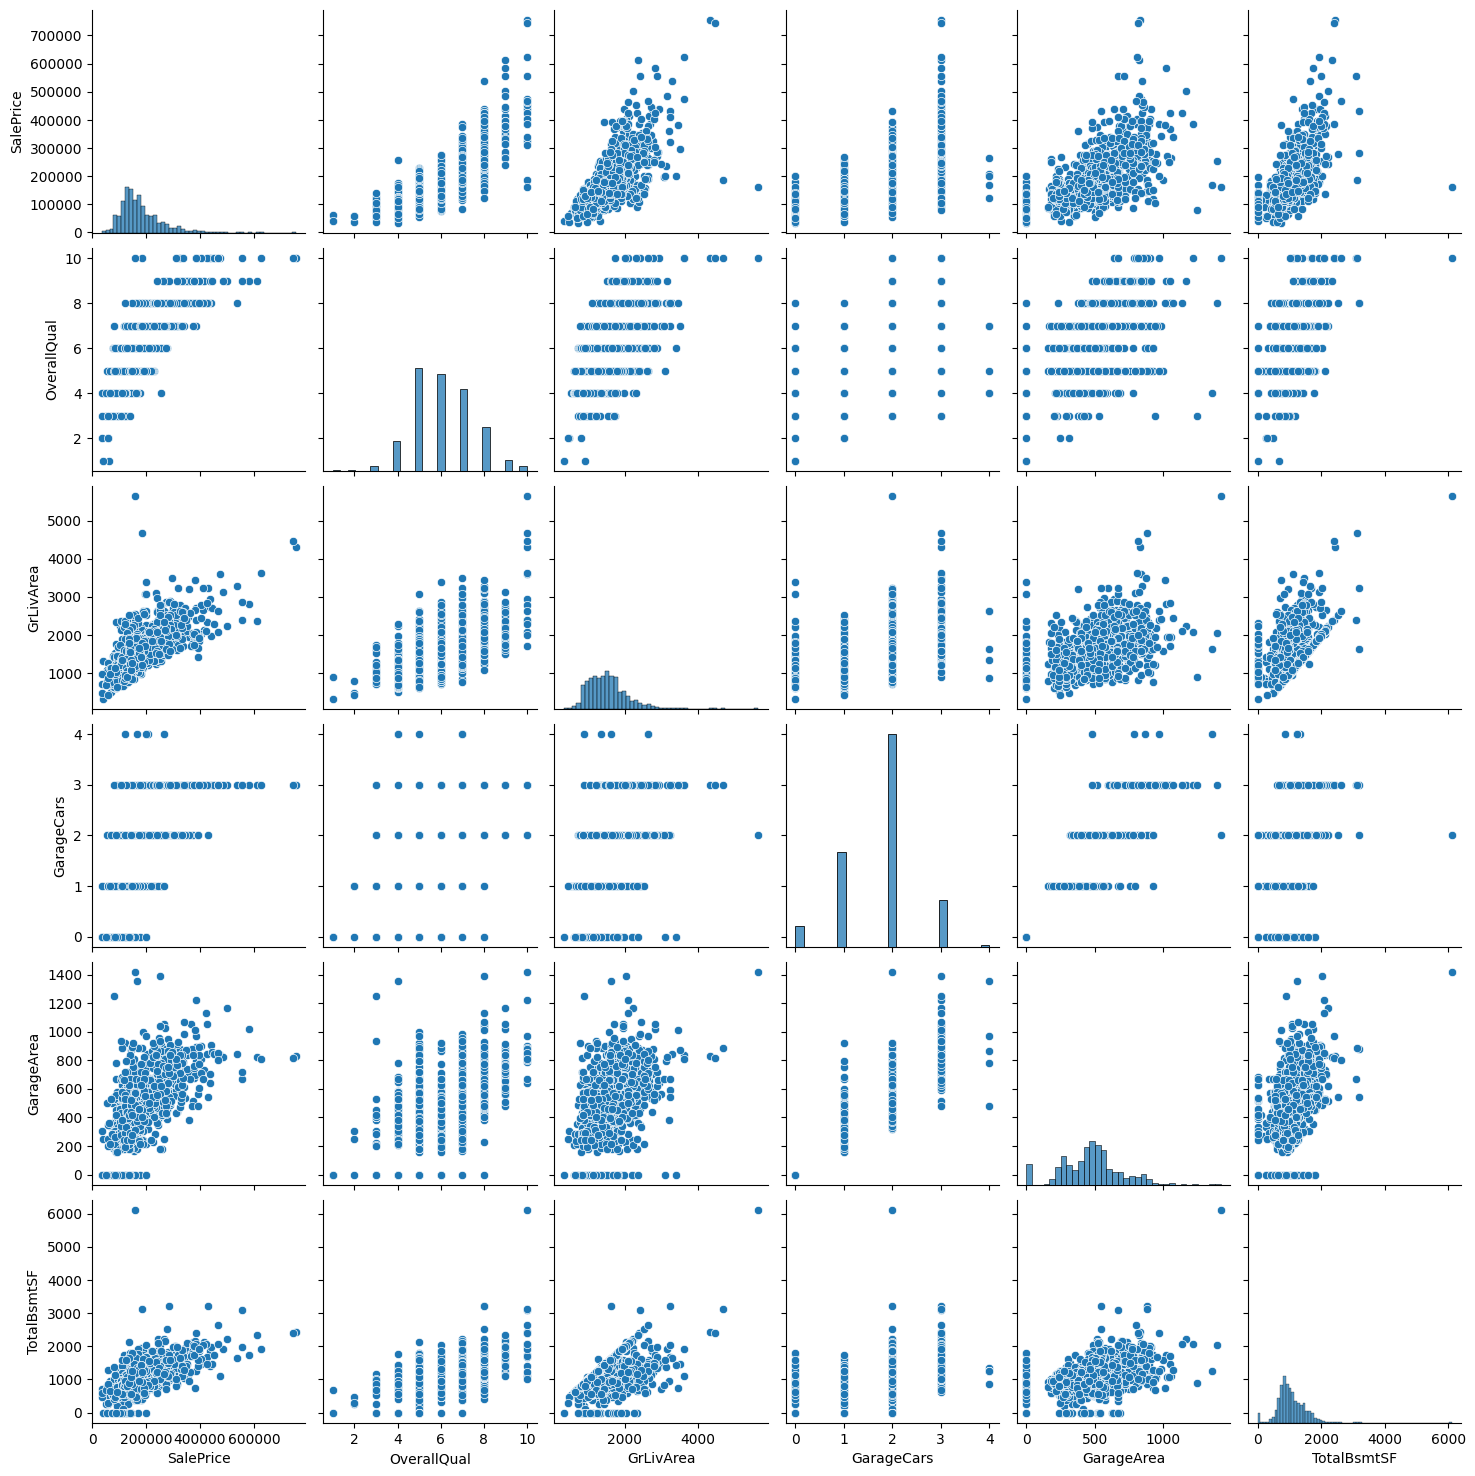

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ['SalePrice',
        'OverallQual',
        'GrLivArea',
        'GarageCars',
        'GarageArea',
        'TotalBsmtSF']
sns.pairplot(df[cols])
plt.show() # 첫번째 줄만 보면 된다

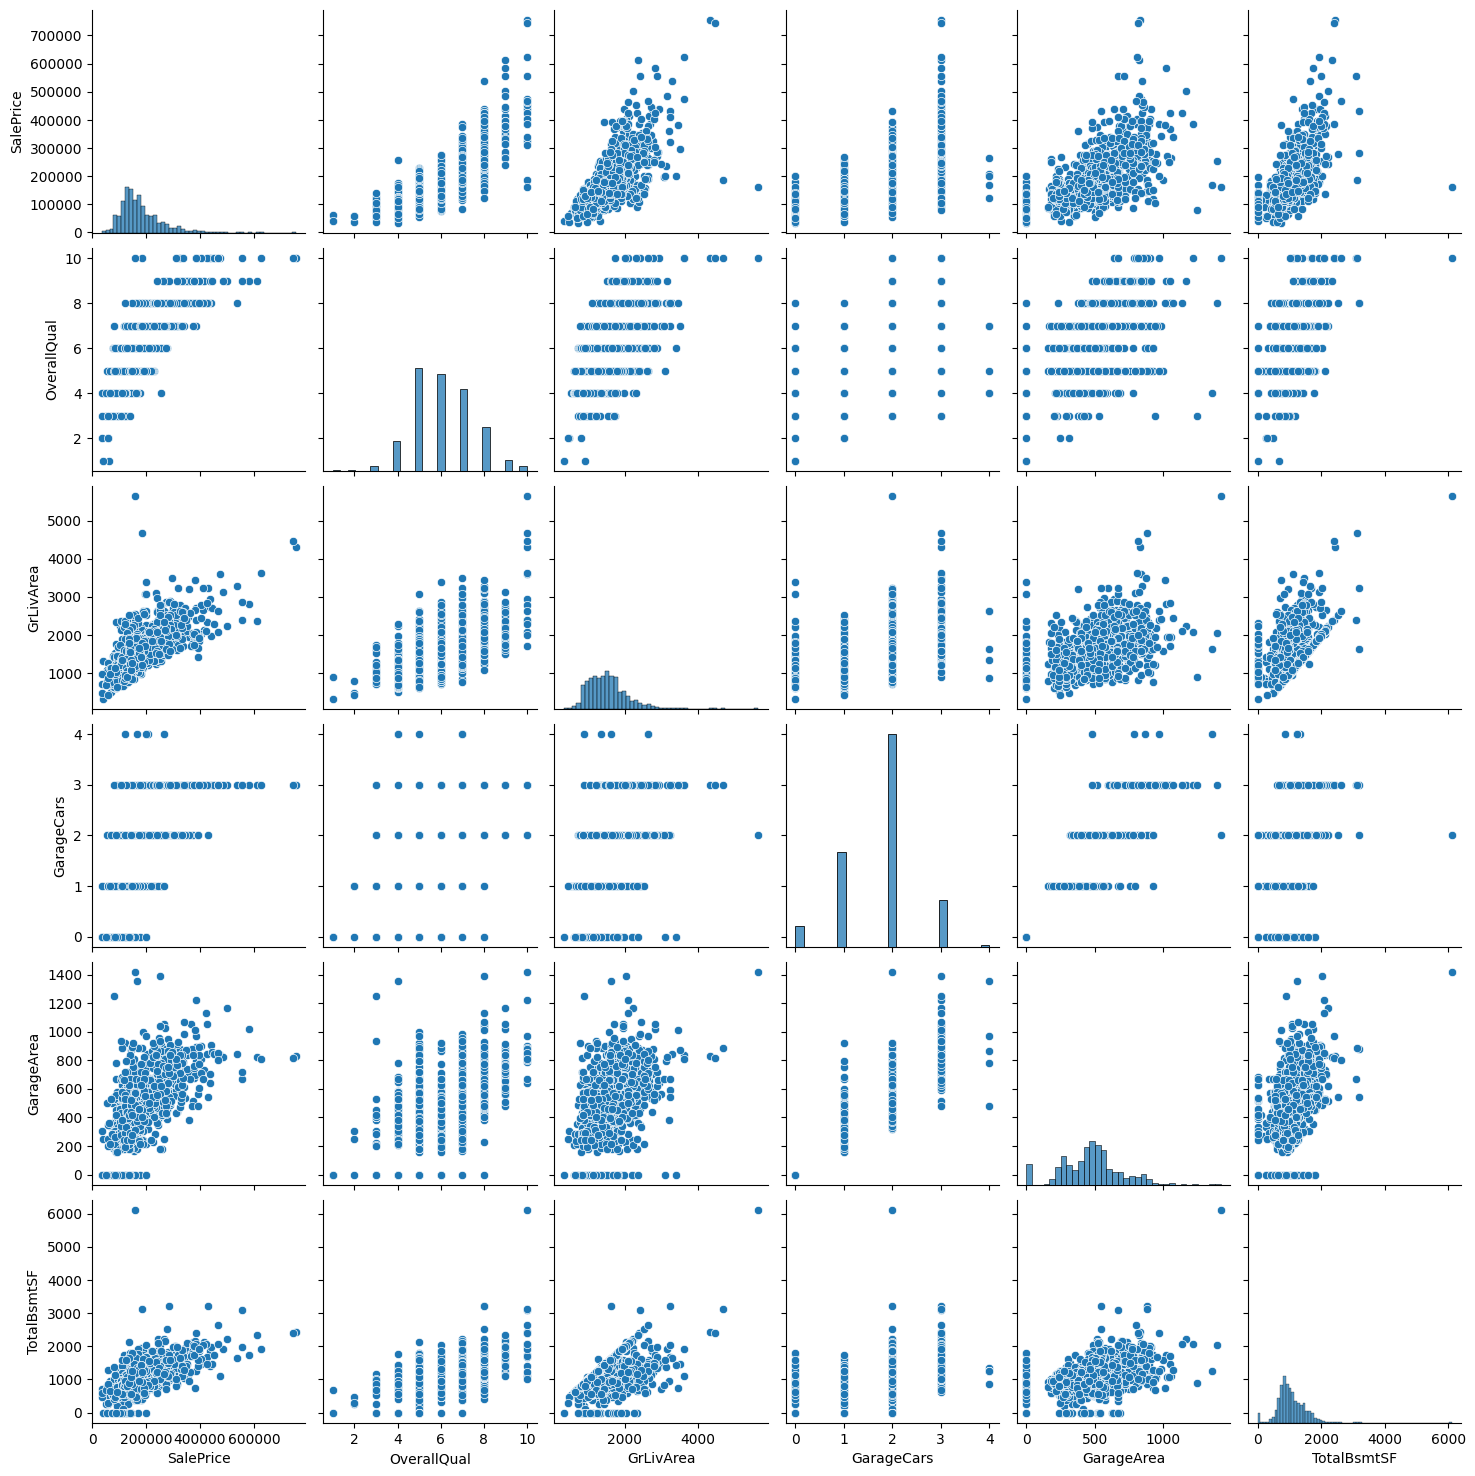

In [61]:
# 좀 더 ^프로그래머^ 다운 코드
# 위에허 추출한 상관관계 상위 6개를 cols에 지정
cols = df_corr_sort['SalePrice'].head(6).index.values
sns.pairplot(df[cols])
plt.show() # 첫번째 줄만 보면 된다

## 주택 가격 예측 모델 학습하기

In [81]:
import pandas as pd
import numpy as np
# tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [76]:
# 데이터 세팅, 관련도 상위 5개 속성만 활용
cols_train = df_corr_sort['SalePrice'].head(6).index.values[1:]

X = df[cols_train]
y = df['SalePrice'].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, test_size=0.2)

(1460, 5) (1460,)


In [88]:
# 모델 구성
model = Sequential([
    Dense(10, input_dim=X_train.shape[1], activation='relu'),
    Dense(30, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1)
])
model.summary()

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 10)                60        
                                                                 
 dense_21 (Dense)            (None, 30)                330       
                                                                 
 dense_22 (Dense)            (None, 40)                1240      
                                                                 
 dense_23 (Dense)            (None, 1)                 41        
                                                                 
Total params: 1,671
Trainable params: 1,671
Non-trainable params: 0
_________________________________________________________________


In [89]:
# set callbacks : earlyStopping & checkpointer
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=200
)

modelpath = './trained_model/ch15/house.hdf5'
checkpointer = ModelCheckpoint(
    filepath=modelpath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

In [90]:
# Do learning
history = model.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping_callback, checkpointer],
                    verbose=1
                   )

Epoch 1/2000
28/28 [==============================] - 1s 5ms/step - loss: 37645103104.0000 - val_loss: 40611241984.0000
Epoch 2/2000
28/28 [==============================] - 0s 3ms/step - loss: 37168672768.0000 - val_loss: 39934345216.0000
Epoch 3/2000
28/28 [==============================] - 0s 3ms/step - loss: 36210692096.0000 - val_loss: 38390009856.0000
Epoch 4/2000
28/28 [==============================] - 0s 2ms/step - loss: 34067499008.0000 - val_loss: 35196653568.0000
Epoch 5/2000
28/28 [==============================] - 0s 2ms/step - loss: 29955545088.0000 - val_loss: 29287710720.0000
Epoch 6/2000
28/28 [==============================] - 0s 2ms/step - loss: 22996402176.0000 - val_loss: 20268177408.0000
Epoch 7/2000
28/28 [==============================] - 0s 2ms/step - loss: 13814541312.0000 - val_loss: 10331277312.0000
Epoch 8/2000
28/28 [==============================] - 0s 2ms/step - loss: 5800062464.0000 - val_loss: 3860483840.0000
Epoch 9/2000
28/28 [======================

Epoch 70/2000
28/28 [==============================] - 0s 2ms/step - loss: 1678931328.0000 - val_loss: 2181566208.0000
Epoch 71/2000
28/28 [==============================] - 0s 2ms/step - loss: 1689239936.0000 - val_loss: 2167696640.0000
Epoch 72/2000
28/28 [==============================] - 0s 2ms/step - loss: 1688082816.0000 - val_loss: 2182048768.0000
Epoch 73/2000
28/28 [==============================] - 0s 2ms/step - loss: 1685077760.0000 - val_loss: 2170289408.0000
Epoch 74/2000
28/28 [==============================] - 0s 2ms/step - loss: 1679141248.0000 - val_loss: 2178596608.0000
Epoch 75/2000
28/28 [==============================] - 0s 2ms/step - loss: 1675625088.0000 - val_loss: 2167463168.0000
Epoch 76/2000
28/28 [==============================] - 0s 2ms/step - loss: 1678106624.0000 - val_loss: 2169024256.0000
Epoch 77/2000
28/28 [==============================] - 0s 2ms/step - loss: 1677288576.0000 - val_loss: 2174338048.0000
Epoch 78/2000
28/28 [===========================

28/28 [==============================] - 0s 2ms/step - loss: 1665263232.0000 - val_loss: 2181232896.0000
Epoch 139/2000
28/28 [==============================] - 0s 2ms/step - loss: 1665674624.0000 - val_loss: 2181188352.0000
Epoch 140/2000
28/28 [==============================] - 0s 2ms/step - loss: 1662028160.0000 - val_loss: 2189912320.0000
Epoch 141/2000
28/28 [==============================] - 0s 2ms/step - loss: 1664649088.0000 - val_loss: 2180461824.0000
Epoch 142/2000
28/28 [==============================] - 0s 2ms/step - loss: 1671195136.0000 - val_loss: 2189944064.0000
Epoch 143/2000
28/28 [==============================] - 0s 2ms/step - loss: 1666449152.0000 - val_loss: 2188808960.0000
Epoch 144/2000
28/28 [==============================] - 0s 2ms/step - loss: 1668355200.0000 - val_loss: 2180176640.0000
Epoch 145/2000
28/28 [==============================] - 0s 2ms/step - loss: 1673505920.0000 - val_loss: 2185160192.0000
Epoch 146/2000
28/28 [==============================] -

28/28 [==============================] - 0s 2ms/step - loss: 1672631680.0000 - val_loss: 2186344960.0000
Epoch 207/2000
28/28 [==============================] - 0s 2ms/step - loss: 1693254528.0000 - val_loss: 2185524224.0000
Epoch 208/2000
28/28 [==============================] - 0s 2ms/step - loss: 1667168512.0000 - val_loss: 2187475968.0000
Epoch 209/2000
28/28 [==============================] - 0s 2ms/step - loss: 1662313728.0000 - val_loss: 2191411968.0000
Epoch 210/2000
28/28 [==============================] - 0s 2ms/step - loss: 1664828672.0000 - val_loss: 2185241088.0000
Epoch 211/2000
28/28 [==============================] - 0s 2ms/step - loss: 1670866944.0000 - val_loss: 2201234944.0000
Epoch 212/2000
28/28 [==============================] - 0s 2ms/step - loss: 1665164928.0000 - val_loss: 2184342784.0000
Epoch 213/2000
28/28 [==============================] - 0s 2ms/step - loss: 1660271488.0000 - val_loss: 2190587136.0000
Epoch 214/2000
28/28 [==============================] -

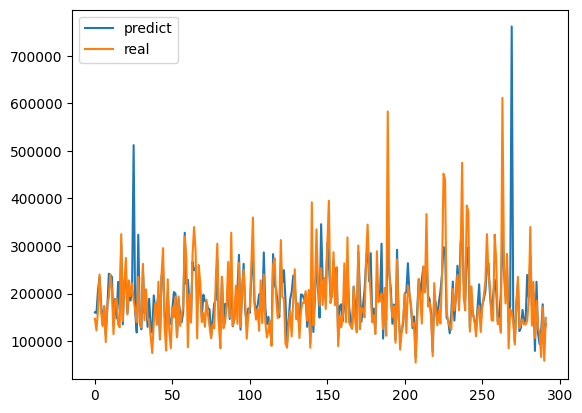

In [105]:
# 학습 모델에 따른 예측 값과 실제 값 비교
index = np.array([i for i in range(y_test.shape[0])])
pred_prices = model.predict(X_test, verbose=0).flatten()
real_prices = y_test

plt.plot(index, pred_prices, label='predict')
plt.plot(index, real_prices, label='real')
plt.legend()
plt.show()

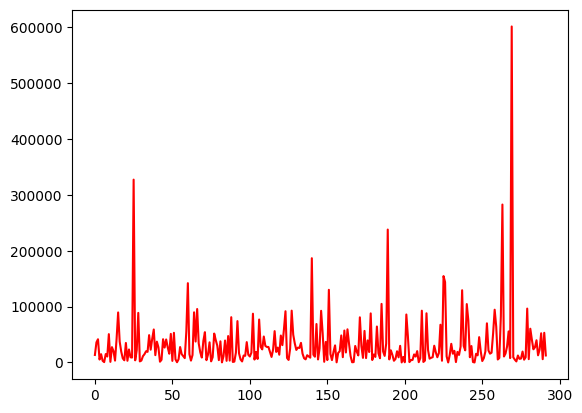

In [104]:
plt.plot(index, np.abs(real_prices-pred_prices), color='red', label='diff')


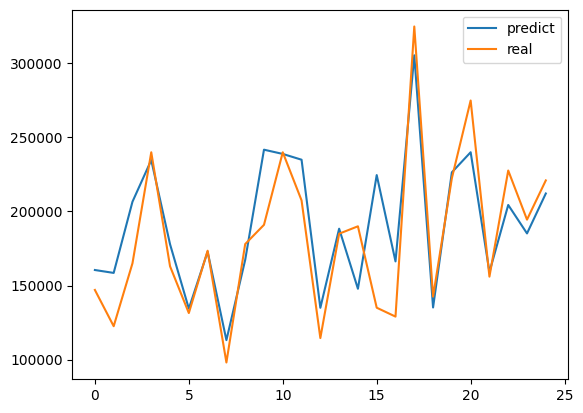

In [106]:
# 학습 모델에 따른 예측 값과 실제 값 비교, 25개만(깔끔하게 보기위해)
size = 25
index = np.array([i for i in range(size)])
pred_prices = model.predict(X_test[:size], verbose=0).flatten()
real_prices = y_test[:size]

plt.plot(index, pred_prices, label='predict')
plt.plot(index, real_prices, label='real')
plt.legend()
plt.show()

### 모든 컬럼 이용하기

(1460, 289) (1460,)


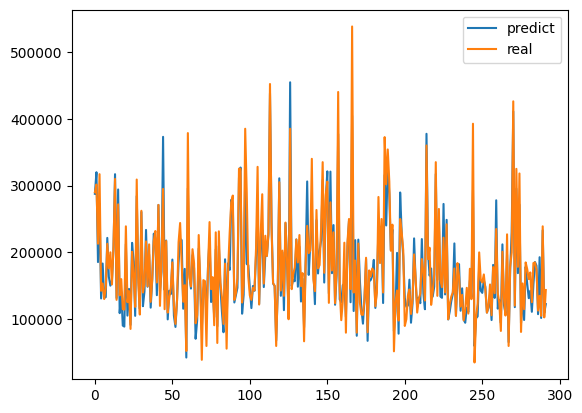

In [108]:
# 데이터 세팅, 모든 속성 활용
cols_train = df_corr_sort['SalePrice'].index.values[1:]

X = df[cols_train]
y = df['SalePrice'].values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, test_size=0.2)

# 모델 구성
model = Sequential([
    Dense(10, input_dim=X_train.shape[1], activation='relu'),
    Dense(30, activation='relu'),
    Dense(40, activation='relu'),
    Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

# set callbacks : earlyStopping & checkpointer
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=200
)

modelpath = './trained_model/ch15/house_by_all_attrs.hdf5'
checkpointer = ModelCheckpoint(
    filepath=modelpath,
    monitor='val_loss',
    verbose=0,
    save_best_only=True
)

# Do learning
history = model.fit(X_train, y_train,
                    epochs=2000,
                    batch_size=32,
                    validation_split=0.25,
                    callbacks=[early_stopping_callback, checkpointer],
                    verbose=0
                   )

# 학습 모델에 따른 예측 값과 실제 값 비교
index = np.array([i for i in range(y_test.shape[0])])
pred_prices = model.predict(X_test, verbose=0).flatten()
real_prices = y_test

plt.plot(index, pred_prices, label='predict')
plt.plot(index, real_prices, label='real')
plt.legend()
plt.show()

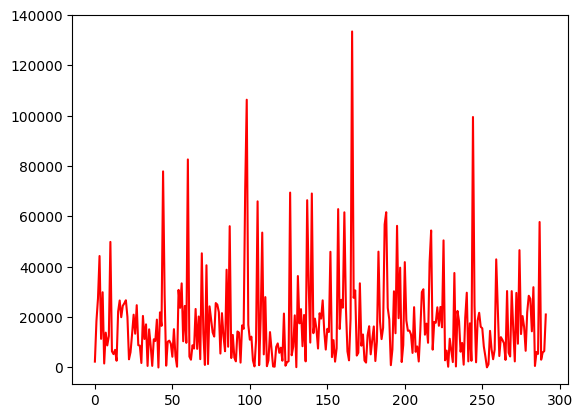

In [109]:
plt.plot(index, np.abs(real_prices-pred_prices), color='red', label='diff')

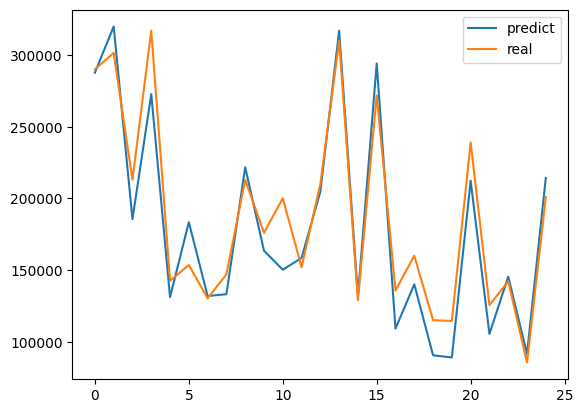

In [110]:
# 학습 모델에 따른 예측 값과 실제 값 비교, 25개만(깔끔하게 보기위해)
size = 25
index = np.array([i for i in range(size)])
pred_prices = model.predict(X_test[:size], verbose=0).flatten()
real_prices = y_test[:size]

plt.plot(index, pred_prices, label='predict')
plt.plot(index, real_prices, label='real')
plt.legend()
plt.show()